In [0]:
import pandas as pd
import numpy as np
import cv2
import pickle

In [0]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [0]:
import matplotlib.pyplot as plt

In [0]:
import seaborn as sns

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
from time import time
import keras
import keras.backend as K
from keras import metrics
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Concatenate, Flatten, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
def load_file(nome_arquivo):
    with open(nome_arquivo, 'rb') as input:
        objeto = pickle.load(input)
    return objeto

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#comandos = pd.concat([pd.DataFrame(load_file('/content/drive/My Drive/Colab Notebooks/comando_new.pkl')),\
#          pd.DataFrame(load_file('/content/drive/My Drive/Colab Notebooks/img_new.pkl'))],\
#          axis=0)
comandos = pd.DataFrame(load_file('/content/drive/My Drive/Colab Notebooks/comando_new.pkl'))

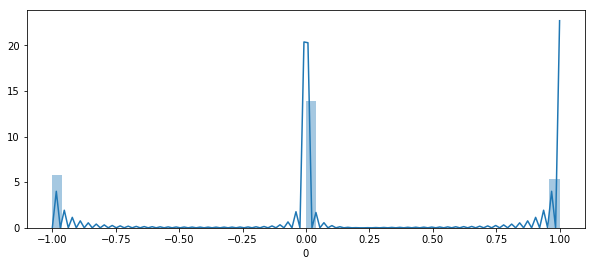

In [0]:
plt.figure(figsize=(10,4))
sns.distplot(comandos[0])
plt.show()

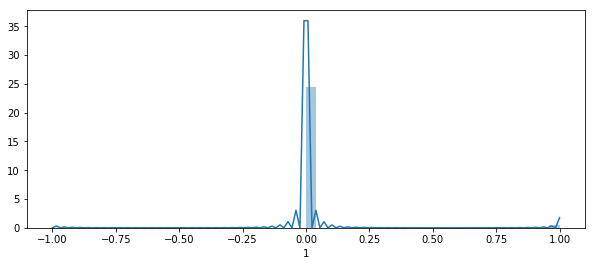

In [0]:
plt.figure(figsize=(10,4))
sns.distplot(comandos[1])
plt.show()

In [0]:
comandos.describe()

,0,1,2,3
count,7000.000000,7000.000000,7000.000000,7000.000000
mean,-0.016857,0.014714,0.845857,0.022714
std,0.667453,0.136016,0.361111,0.149002
min,-1.000000,-1.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [0]:
comandos['direita'] = comandos[0].map(lambda x: 1 if x == 1 else 0)
comandos['esquerda'] = comandos[0].map(lambda x: 1 if x == -1 else 0)
comandos['baixo'] = comandos[1].map(lambda x: 1 if x == 1 else 0)
comandos['cima'] = comandos[1].map(lambda x: 1 if x == -1 else 0)

In [0]:
comandos = comandos[[2,3,'direita','esquerda','cima','baixo']].rename(index=str, columns={2:'acelera',3:'freia'})

In [0]:
"""
imagens = []
for img in load_file('/content/drive/My Drive/Colab Notebooks/img.pkl'):
  imagens.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255)
for img in load_file('/content/drive/My Drive/Colab Notebooks/img2.pkl'):
  imagens.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255)
"""
imagens = load_file('/content/drive/My Drive/Colab Notebooks/img_new.pkl')

In [0]:
imgs = []
for img in imagens:
  imgs.append(img/255)

In [0]:
imagens =  np.array(imgs).reshape((7000, 220, 320,1))

In [0]:
imagens.shape

(7000, 220, 320, 1)

In [0]:
comandos.columns

Index(['acelera', 'freia', 'direita', 'esquerda', 'cima', 'baixo'], dtype='object')

In [0]:
comandos = comandos[['freia', 'direita', 'esquerda']]

In [0]:
del imgs

In [0]:
import gc
gc.collect()

10129

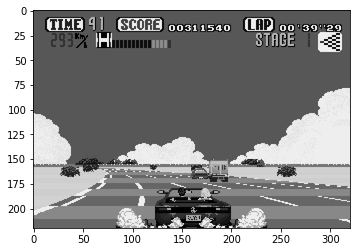

In [0]:
plt.imshow(imagens[100,:,:,:].reshape((220,320)),cmap='gray', vmin=0, vmax=1)

In [0]:
comandos.iloc[100]

freia       0
direita     0
esquerda    1
Name: 100, dtype: int64

In [0]:
#input_shape = (img_rows, img_cols, 1)
input_shape = (220, 320,1)
num_classes = comandos.shape[1]
batch_size = 128
epochs = 140 #600

In [0]:
# CRIANDO MODELO

model = Sequential()
model.add(Conv2D(24, kernel_size=(10, 10), strides=(2, 2), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))
model.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(num_classes, activation='sigmoid'))

W0831 14:17:05.555456 139995498018688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0831 14:17:05.592324 139995498018688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0831 14:17:05.598969 139995498018688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0831 14:17:05.631292 139995498018688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0831 14:17:05.631943 1399954980

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 106, 156, 24)      2424      
_________________________________________________________________
batch_normalization_1 (Batch (None, 106, 156, 24)      96        
_________________________________________________________________
activation_1 (Activation)    (None, 106, 156, 24)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 76, 36)        21636     
_________________________________________________________________
batch_normalization_2 (Batch (None, 51, 76, 36)        144       
_________________________________________________________________
activation_2 (Activation)    (None, 51, 76, 36)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 51, 76, 36)       

In [0]:
# train, test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(range(0,comandos.shape[0]),range(0,comandos.shape[0]), test_size=0.1, random_state=42)

In [0]:
#model.compile(loss=keras.losses.binary_crossentropy,
#              optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
#              metrics=['accuracy'])
INIT_LR = 1e-3
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / epochs),
              metrics=['acc'])

W0831 14:17:09.500696 139995498018688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0831 14:17:09.509095 139995498018688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
imagens[X_train,:,:,:].shape,comandos.shape

((6300, 220, 320, 1), (7000, 3))

In [0]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=20,verbose=0, mode='min')
mcp_save = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/modelo_outrun_3_outputs.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='auto')
#imagens[X_train,:,:,:] imagens[X_test,:,:,:]
model.fit(imagens[X_train,:,:,:], comandos.iloc[X_train].values,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          shuffle = True,
          validation_data=(imagens[X_test,:,:,:], comandos.iloc[X_test].values))
          #,callbacks=[reduce_lr_loss,mcp_save])
score = model.evaluate(imagens[X_test,:,:,:], comandos.iloc[X_test].values, verbose=0)
print('Test loss:', score[0])

Train on 6300 samples, validate on 700 samples
Epoch 1/140
6300/6300 [==============================] - 16s 3ms/step - loss: 1.1205 - acc: 0.7737 - val_loss: 0.8681 - val_acc: 0.8433
Epoch 2/140
6300/6300 [==============================] - 9s 1ms/step - loss: 0.7383 - acc: 0.8268 - val_loss: 0.7255 - val_acc: 0.8433
Epoch 3/140
6300/6300 [==============================] - 9s 1ms/step - loss: 0.7092 - acc: 0.8286 - val_loss: 0.7243 - val_acc: 0.8433
Epoch 4/140
6300/6300 [==============================] - 9s 1ms/step - loss: 0.6206 - acc: 0.8292 - val_loss: 0.5118 - val_acc: 0.8433
Epoch 5/140
6300/6300 [==============================] - 9s 1ms/step - loss: 0.5331 - acc: 0.8276 - val_loss: 0.4868 - val_acc: 0.7795
Epoch 6/140
6300/6300 [==============================] - 9s 1ms/step - loss: 0.4698 - acc: 0.8312 - val_loss: 0.4317 - val_acc: 0.8433
Epoch 7/140
6300/6300 [==============================] - 9s 1ms/step - loss: 0.4356 - acc: 0.8377 - val_loss: 0.5010 - val_acc: 0.8433
Epoch 8

In [0]:
resultados = pd.DataFrame(model.predict_proba(imagens),columns=['freia', 'direita', 'esquerda']).round(2)

In [0]:
resultados.sample(n=20)

,freia,direita,esquerda
2868,0.00,0.14,0.09
2724,0.09,0.02,0.67
3946,0.00,0.07,0.04
3901,0.00,0.11,0.06
1786,0.00,0.24,0.14
6487,0.00,0.09,0.05
1342,0.00,0.07,0.06
6330,0.09,0.03,0.62
5213,0.00,0.00,0.00
5041,0.00,0.02,0.01


In [0]:
model.save_weights("/content/drive/My Drive/Colab Notebooks/model_3_outputs.h5")

In [0]:
resultados.describe()

,freia,direita,esquerda
count,7000.000000,7000.000000,7000.000000
mean,0.076130,0.308783,0.306051
std,0.056692,0.048004,0.044500
min,0.000000,0.020000,0.040000
25%,0.050000,0.300000,0.290000
50%,0.050000,0.300000,0.300000
75%,0.090000,0.320000,0.330000
max,0.270000,0.400000,0.390000


#### Loading my Model

In [0]:
def generate_model():
  model = Sequential()
  model.add(Conv2D(24, kernel_size=(10, 10), strides=(2, 2), activation='relu', input_shape=input_shape))
  model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
  model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(2056, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(num_classes, activation='sigmoid'))
  
  return model

In [0]:
modelz = generate_model()

In [0]:
modelz.load_weights('/content/drive/My Drive/Colab Notebooks/modelo_outrun_3_outputs.hdf5')

In [0]:
type(model)

In [0]:
imagens.shape

In [0]:
resultados = pd.DataFrame(modelz.predict_proba(imagens),columns=['freia', 'direita', 'esquerda']).round(2)

In [0]:
resultados.describe()

------------------------------------------------------------------------------------------------------------------------

# Roc of the Models

In [0]:
comandos.columns

Index(['freia', 'direita', 'esquerda'], dtype='object')

In [0]:
def curva_roc(df_target,predictions,title=''):
    fpr, tpr, threshold = roc_curve(df_target, predictions)
    plt.figure(figsize=(8,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(df_target, predictions))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic REAIS'+title)
    plt.legend(loc="lower right")
    plt.show()

In [0]:
def limiar_escore(df_target,predictions):
    #Imprimindo limiar de Escore
    fpr, tpr, threshold = roc_curve(df_target, predictions)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    print('Limiar que maxima especificidade e sensitividade:')
    print(list(roc_t['threshold']))
    #analisando modelo com novo limiar
    tn, fp, fn, tp = confusion_matrix(df_target, [1 if item>=list(roc_t['threshold'])[0] else 0 for item in predictions]).ravel()
    Precision = tp/(tp+fp)
    Recall = tp/(tp+fn)
    acuracia = (tp+tn)/(tn+fp+fn+tp)
    F = (2*Precision*Recall)/(Precision+Recall)
    print('Precision',Precision)
    print('Recall',Recall)
    print('Acuracia',acuracia)
    print('F-Score',F)

Freio

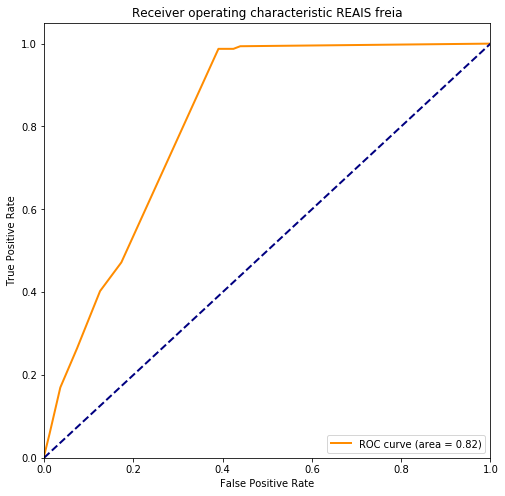

Limiar que maxima especificidade e sensitividade:
[0.07000000029802322]
Precision 0.059571088165210485
Recall 0.4716981132075472
Acuracia 0.8188571428571428
F-Score 0.10578279266572638


In [0]:
curva_roc(comandos['freia'],resultados['freia'],' freia')

limiar_escore(comandos['freia'],resultados['freia'])

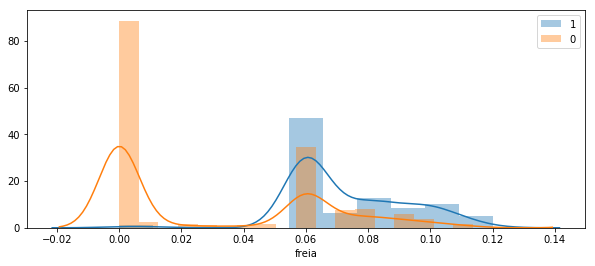

In [0]:
plt.figure(figsize=(10,4))
sns.distplot(resultados['freia'].iloc[comandos[comandos['freia'] == 1].index])
sns.distplot(resultados['freia'].iloc[comandos[comandos['freia'] == 0].index])
plt.legend([1,0])
plt.show()

direita

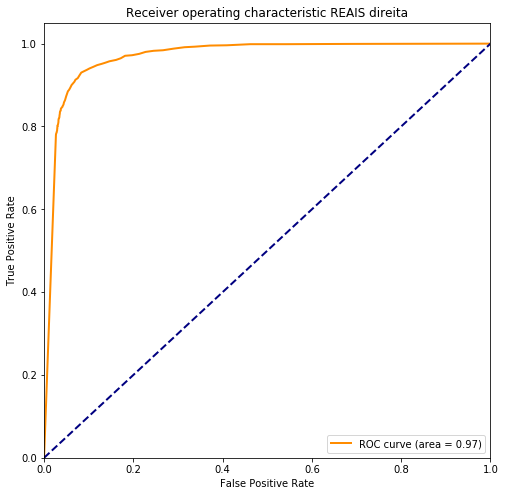

Limiar que maxima especificidade e sensitividade:
[0.25999999046325684]
Precision 0.7607025246981339
Recall 0.9233844103930713
Acuracia 0.9212857142857143
F-Score 0.8341859765272345


In [0]:
curva_roc(comandos['direita'],resultados['direita'],' direita')

limiar_escore(comandos['direita'],resultados['direita'])

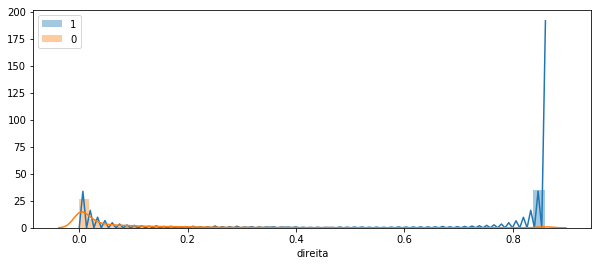

In [0]:
plt.figure(figsize=(10,4))
sns.distplot(resultados['direita'].iloc[comandos[comandos['direita'] == 1].index])
sns.distplot(resultados['direita'].iloc[comandos[comandos['direita'] == 0].index])
plt.legend([1,0])
plt.show()

Esquerda

In [0]:
comandos['esquerda'].value_counts(normalize=True)

0    0.768714
1    0.231286
Name: esquerda, dtype: float64

In [0]:
resultados['esquerda'].unique()

array([0.        , 0.01      , 0.07      , 0.1       , 0.02      ,
       0.85000002, 0.83999997, 0.04      , 0.18000001, 0.54000002,
       0.87      , 0.2       , 0.14      , 0.31      , 0.05      ,
       0.03      , 0.13      , 0.28999999, 0.75999999, 0.30000001,
       0.64999998, 0.86000001, 0.92000002, 0.37      , 0.69999999,
       0.77999997, 0.17      , 0.76999998, 0.93000001, 0.73000002,
       0.75      , 0.88      , 0.25      , 0.44      , 0.67000002,
       0.55000001, 0.47      , 0.69      , 0.58999997, 0.49000001,
       0.63999999, 0.52999997, 0.81999999, 0.91000003, 0.74000001,
       0.15000001, 0.06      , 0.56999999, 0.47999999, 0.23999999,
       0.08      , 0.12      , 0.51999998, 0.25999999, 0.20999999,
       0.09      , 0.38      , 0.19      , 0.22      , 0.33000001,
       0.16      , 0.23      , 0.63      , 0.11      , 0.43000001,
       0.62      , 0.44999999, 0.82999998, 0.81      , 0.79000002,
       0.50999999, 0.70999998, 0.40000001, 0.27000001, 0.61000

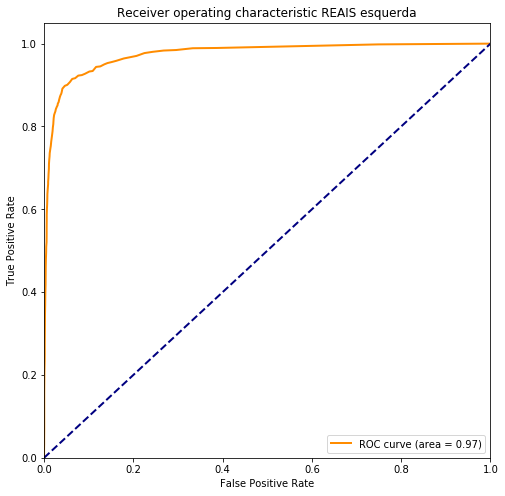

Limiar que maxima especificidade e sensitividade:
[0.20999999344348907]
Precision 0.7838405036726128
Recall 0.922791846819024
Acuracia 0.9232857142857143
F-Score 0.847659574468085


In [0]:
curva_roc(comandos['esquerda'],resultados['esquerda'],' esquerda')

limiar_escore(comandos['esquerda'],resultados['esquerda'])

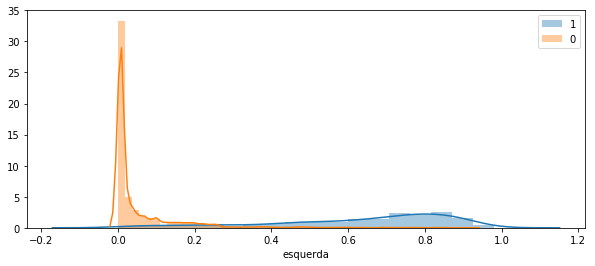

In [0]:
plt.figure(figsize=(10,4))
sns.distplot(resultados['esquerda'].iloc[comandos[comandos['esquerda'] == 1].index])
sns.distplot(resultados['esquerda'].iloc[comandos[comandos['esquerda'] == 0].index])
plt.legend([1,0])
plt.show()

Cima

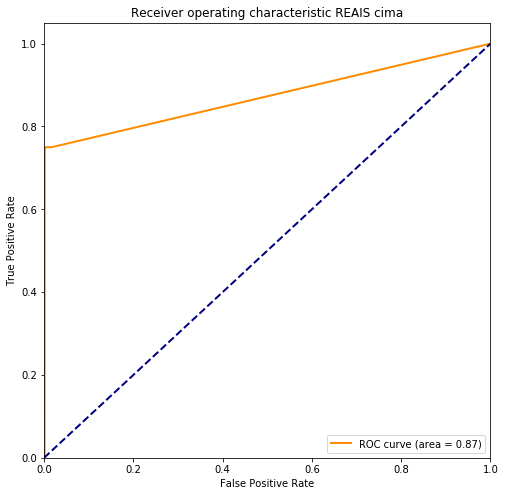

Limiar que maxima especificidade e sensitividade:
[0.009999999776482582]
Precision 0.0625
Recall 0.75
Acuracia 0.9823889739663093
F-Score 0.11538461538461539


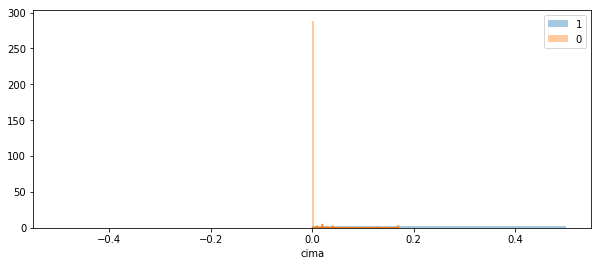

In [0]:
curva_roc(comandos['cima'],resultados['cima'],' cima')

limiar_escore(comandos['cima'],resultados['cima'])

plt.figure(figsize=(10,4))
sns.distplot(resultados['cima'].iloc[comandos[comandos['cima'] == 1].index])
sns.distplot(resultados['cima'].iloc[comandos[comandos['cima'] == 0].index])
plt.legend([1,0])
plt.show()

Baixo

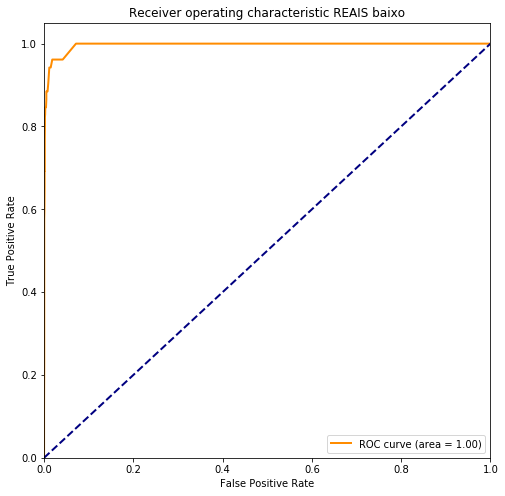

Limiar que maxima especificidade e sensitividade:
[0.029999999329447746]
Precision 0.3184713375796178
Recall 0.9615384615384616
Acuracia 0.9582695252679939
F-Score 0.4784688995215311


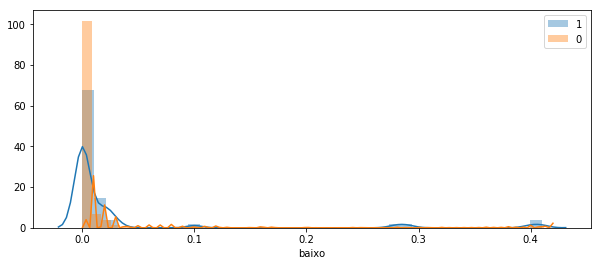

In [0]:
curva_roc(comandos['baixo'],resultados['baixo'],' baixo')

limiar_escore(comandos['baixo'],resultados['baixo'])

plt.figure(figsize=(10,4))
sns.distplot(resultados['baixo'].iloc[comandos[comandos['baixo'] == 1].index])
sns.distplot(resultados['baixo'].iloc[comandos[comandos['baixo'] == 0].index])
plt.legend([1,0])
plt.show()

-------------------------------------------------------------------END-----------------------------------------------------------------------------